# Advanced Lane Finding Project

## Step 1: Camera Calibration

In [2]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

# Read in the calibration images
cal_images = glob.glob('./camera_cal/calibration*.jpg')

# Arrays to store object points (perfect chessboard) and image points (chessboard corner points from images)
objpoints = []
imgpoints = []

# Chessboard dimensions
nx = 9
ny = 6
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

for image in cal_images:
    # Read image in RGB
    img = mpimg.imread(image)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    # If corners found, add to image & object points arrays
    if ret==True:
        objpoints.append(objp)
        imgpoints.append(corners)

# Get the camera calibration matrices and distortion coefficients
gray_shape = cv2.cvtColor(mpimg.imread(cal_images[0]), cv2.COLOR_RGB2GRAY).shape
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray_shape, None, None)

print("Camera Matrix and Distortion Coefficients found...")

Camera Matrix and Distortion Coefficients found...


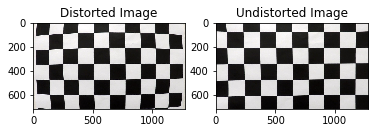

In [59]:
img = mpimg.imread('./camera_cal/calibration1.jpg')
plt.figure()
plt.subplot(1,2,1)
plt.title('Distorted Image')
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(cv2.undistort(img, mtx, dist, None, mtx))
plt.title('Undistorted Image')
plt.savefig('Chessboard_undist')

## Image Pipeline

In [62]:
# Hardcode the source and destination points for the Camera Perspective Matrix (Assumes camera perspective remains const)
src = np.float32([[291, 692],
      [552, 506],
      [805, 506],
      [1112, 692]])

dest = np.float32([[450, 650],
       [450, 350],
       [1100, 350],
       [1100, 650]])

M = cv2.getPerspectiveTransform(src, dest)
Minv = cv2.getPerspectiveTransform(dest, src)

def sobel_mask(gray, orient='x', thresh=(0, 255), ksize=3):
    '''
    Returns bitmask for given sobel threshold
    '''
    if orient is 'x':
        sob = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize)
    elif orient is 'y':
        sob = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize)
    else:
        raise Exception('Invalid orientation specified. Valid: Either \'x\' or \'y\'')
    
    abs_sob = np.absolute(sob)
    scaled_sob = np.uint8(255 * abs_sob / np.max(abs_sob))
    mask = np.zeros_like(scaled_sob)
    mask[(scaled_sob > thresh[0]) & (scaled_sob < thresh[1])] = 1
    return mask

def grad_mag(gray, thresh=(0, 255), ksize=3):
    '''
    Implements a gradient magnitude threshold for grayscale images
    '''
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255 * sobel / np.max(sobel))
    mask = np.zeros_like(scaled_sobel)
    mask[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    return mask
    
    
def grad_dir(gray, thresh=(0, np.pi/2), ksize=3):
    '''
    Implements a gradient direction threshold for grayscale images
    '''
    sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize))
    sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize))
    direction = np.arctan2(sobely, sobelx)
    mask = np.zeros_like(direction)
    mask[(direction > thresh[0]) & (direction < thresh[1])] = 1
    mask = mask.astype('uint8')
    return mask

def saturation_thresh(rgb, thresh=(0, 255)):
    '''
    Implements a saturation channel threshold for RGB images
    '''
    hls = cv2.cvtColor(rgb, cv2.COLOR_RGB2HLS)
    sat = hls[:,:,2]
    mask = np.zeros_like(sat).astype('uint8')
    mask[(sat > thresh[0]) & (sat <= thresh[1])] = 1

    return mask

def hue_thresh(rgb, thresh=(0, 255)):
    '''
    Implements a hue channel threshold for RGB images
    '''
    hls = cv2.cvtColor(rgb, cv2.COLOR_RGB2HLS)
    hue = hls[:,:,0]
    mask = np.zeros_like(hue).astype('uint8')
    mask[(hue > thresh[0]) & (hue <= thresh[1])] = 1
    return mask

def red_thresh(rgb, thresh=(0,255)):
    '''
    Implements a red channel threshold for RGB images
    '''
    red = rgb[:,:,0]
    mask = np.zeros_like(red)
    mask[(red > thresh[0]) & (red < thresh[1])] = 1
    return mask

def green_thresh(rgb, thresh=(0,255)):
    '''
    Implements a green channel threshold for RGB images
    '''
    green = rgb[:,:,1]
    mask = np.zeros_like(green)
    mask[(green > thresh[0]) & (green < thresh[1])] = 1
    return mask

class Lane:
    def __init__(self, hist_size):
        self.hist_size = hist_size
        self.roc_left = []
        self.roc_right = []
        self.lane_off = []
        self.idx = 0
    
    def updateParameters(self, roc_left, roc_right, lane_off):
        if(self.idx >= self.hist_size):
            self.idx = 0
        if(len(self.roc_left) < self.hist_size):
            self.roc_left.append(roc_left)
            self.roc_right.append(roc_right)
            self.lane_off.append(lane_off)
        else:
            self.roc_left[self.idx] = roc_left
            self.roc_right[self.idx] = roc_right
            self.lane_off[self.idx] = lane_off
        
        self.idx += 1
    
    def getAverages(self):
        num_vals = len(self.roc_left)
        return sum(self.roc_left)/num_vals, sum(self.roc_right)/num_vals, sum(self.lane_off)/num_vals
            
        
lane = Lane(5)
leftx_base = None
rightx_base = None

def processImage(img):
    '''
    Image processing pipeline for lane detection
    @param img: A RGB image of a car driving on a road
    @return result: Undistorted image annotated with lane lines, Radius of Curvature and Lane position
    '''
    # Undistort Image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
#     plt.figure()
#     plt.subplot(1,2,1)
#     plt.title('Distorted Image')
#     plt.imshow(img)
#     plt.subplot(1,2,2)
#     plt.imshow(cv2.undistort(img, mtx, dist, None, mtx))
#     plt.title('Undistorted Image')
#     plt.savefig('images/lane_undist')
    
    # Convert to grayscale for Sobel thresholding
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    gray = cv2.equalizeHist(gray)
    
    # ROI Thresholding
    imshape = undist.shape
    mask_roi = np.zeros_like(gray)
    vertices = np.array([[(0,imshape[0]), (0.4*imshape[1], 0.5*imshape[0]), (0.6*imshape[1], 0.5*imshape[0]), (imshape[1],imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask_roi, vertices, 255)
        
    # Sobel (Gradient) Thresholding
    sobel_x_mask = sobel_mask(gray, 'x', (50, 255), ksize=3)
    sobel_y_mask = sobel_mask(gray, 'y', (50, 255), ksize=3)
    #sobel_mag_mask = grad_mag(gray, (50, 255), ksize=15) NOT USED
    sobel_dir_mask = grad_dir(gray, (0.7, 1.3), ksize=3)
    
    # Color Thresholding
    sat_mask = saturation_thresh(undist, (80, 255))
    #hue_mask = hue_thresh(undist, (50, 255)) NOT USED
    red_mask = red_thresh(undist, (120, 255))
    green_mask = green_thresh(undist, (200, 255))
    
    # Combined Thresholding
    combined = np.zeros_like(sobel_x_mask)
    combined[((sat_mask == 1) | (sobel_x_mask == 1) & (sobel_y_mask==1)) & (sobel_dir_mask == 1)] = 1
    combined[(red_thresh == 0) | (green_thresh == 0)] = 0
    combined = cv2.bitwise_and(combined, mask_roi)
    
#     plt.figure()
#     plt.title('Combined Thresholding Result')
#     plt.imshow(combined, cmap='gray')
#     plt.savefig('images/combined_threshold')
    
    # Perspective Transformation
    img_size = (undist.shape[1], undist.shape[0])
    img_warp = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)
#     plt.figure()
#     plt.subplot(1,2,1)
#     plt.imshow(cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR))
#     plt.title('Perspective Undistort')
#     plt.subplot(1,2,2)
#     plt.imshow(img_warp, cmap='gray')
#     plt.title('Perspective Thresholding')
#     plt.savefig('images/perspective')
    
    # LANE FINDING
    hist = np.sum(img_warp[np.int(img_warp.shape[0]/2):, :], axis=0)
    midpoint = np.int(hist.shape[0]/2)
    leftx_base = np.argmax(hist[:midpoint])
    rightx_base = np.argmax(hist[midpoint:]) + midpoint
        
    out_img = np.dstack((img_warp, img_warp, img_warp)) * 255
    
    nwindows = 8
    window_height = np.int(img_warp.shape[0]/nwindows)
    nonzero = img_warp.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 100
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        win_y_low = img_warp.shape[0] - (window+1)*window_height
        win_y_high = img_warp.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, img_warp.shape[0]-1, img_warp.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#     plt.figure()
#     plt.imshow(out_img)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)
#     plt.savefig('images/perspective_lanelines')
    
    # Plot lanes lines on undistorted image in driver's view
    warp_zero = np.zeros_like(img_warp).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
#     plt.figure()
#     plt.imshow(result)
#     plt.title('Final Result')
#     plt.savefig('images/result')
     
    # Calculate Radius of Curvature (at user's location) and Distance from lane center
    lane_width = 3.7 # m
    lane_width_px = np.average(right_fitx - left_fitx)
    conv_px_to_m = lane_width / lane_width_px
    lane_pos_px = (right_fitx[0] + left_fitx[0]) / 2
    lane_pos_m = (lane_pos_px - result.shape[1]/2) * conv_px_to_m
    
    y = undist.shape[0]
    dxdy_left = 2*left_fit[0]*y + left_fit[1]
    dxdy2_left = 2*left_fit[0]
    R_left = conv_px_to_m * (1 + dxdy_left**2)**1.5 / abs(dxdy2_left)
    
    dxdy_right = 2*right_fit[0]*y + right_fit[1]
    dxdy2_right = 2*right_fit[0]
    R_right = conv_px_to_m * (1 + dxdy_right**2)**1.5 / abs(dxdy2_right)
    
    lane.updateParameters(R_left, R_right, lane_pos_m)
    R_left, R_right, lane_pos_m = lane.getAverages()
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,'Radius-Left: {:.1f} m, Radius-Right: {:.1f} m, Lane Offset: {:.1f} m'.format(R_left, R_right, lane_pos_m), (50, 50), font, 1,(255,255,255),5)
    
    return result

## Test on Images

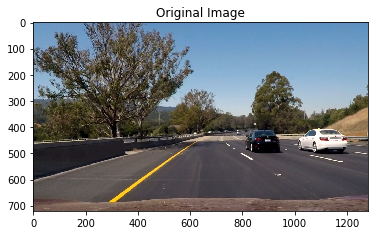

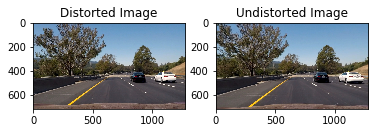

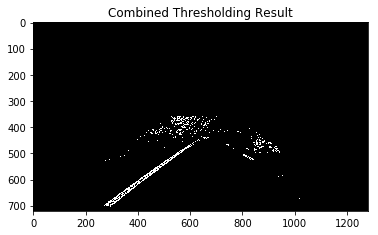

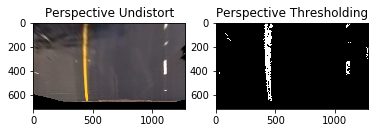

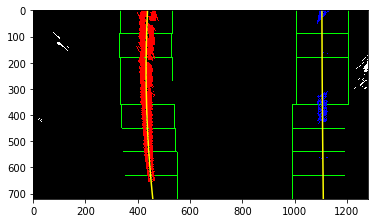

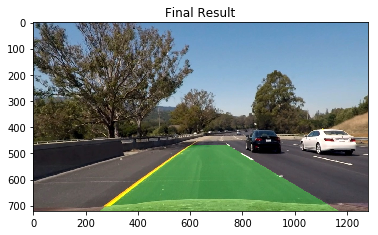

In [63]:
image = './test_images/test6.jpg'
image = mpimg.imread(image)
plt.figure()
plt.title('Original Image')
plt.imshow(image)
thresholded_img = processImage(image)

## Test on Videos

In [57]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
video = 'solution.mp4'
clip = VideoFileClip('project_video.mp4')
clip_sol = clip.fl_image(processImage)
%time clip_sol.write_videofile(video, audio=False)

[MoviePy] >>>> Building video solution.mp4
[MoviePy] Writing video solution.mp4


100%|█████████▉| 1260/1261 [04:11<00:00,  5.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: solution.mp4 

CPU times: user 4min 16s, sys: 52.8 s, total: 5min 9s
Wall time: 4min 12s


In [58]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(video))